<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install tensorflow keras_tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras_tuner] [keras_tuner]


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                           ConfusionMatrixDisplay, roc_curve, auc, f1_score, accuracy_score,
                           precision_score, recall_score, matthews_corrcoef, precision_recall_curve)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Configuración de semilla para reproducibilidad
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

print(f"Dataset shape: {df.shape}")
print(f"Distribución de clases:\n{df['CLASS_LABEL'].value_counts()}")

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']


Dataset shape: (10000, 49)
Distribución de clases:
CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64


In [13]:
class PhishingNeuralNetwork:
    """
    Clase mejorada para implementar red neuronal MLP para detección de phishing
    optimizada para datasets balanceados con mejores prácticas de ML.
    """
    
    def __init__(self, random_state: int = 42, validation_split: float = 0.2):
        self.random_state = random_state
        self.validation_split = validation_split

        np.random.seed(random_state)
        tf.random.set_seed(random_state)

        self.scaler = RobustScaler()
        self.alternative_scaler = StandardScaler()

        self.best_model = None
        self.tuner = None
        self.history = None
        self.cv_scores = None

        self.input_dim = None
        self.best_params = None

    def build_model(self, hp):
        model = keras.Sequential()
        model.add(layers.InputLayer(input_shape=(self.input_dim,)))

        if hp.Boolean('use_batch_norm'):
            model.add(layers.BatchNormalization())

        activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'elu', 'swish'])
        reg_type = hp.Choice('regularization_type', values=['l1', 'l2', 'l1_l2'])
        reg_strength = hp.Float('reg_strength', min_value=1e-5, max_value=1e-1, sampling='LOG')

        if reg_type == 'l1':
            regularizer = keras.regularizers.l1(reg_strength)
        elif reg_type == 'l2':
            regularizer = keras.regularizers.l2(reg_strength)
        else:
            regularizer = keras.regularizers.l1_l2(l1=reg_strength/2, l2=reg_strength/2)

        n_layers = hp.Int('n_hidden_layers', min_value=1, max_value=4)

        for i in range(n_layers):
            if i == 0:
                units = hp.Int(f'units_layer_{i}', min_value=32, max_value=512, step=32)
            else:
                prev_units = hp.get(f'units_layer_{i-1}')
                max_units = max(32, prev_units)
                units = hp.Int(f'units_layer_{i}', min_value=16, max_value=max_units, step=16)

            model.add(layers.Dense(
                units,
                activation=activation,
                kernel_regularizer=regularizer,
                kernel_initializer='he_normal',
                name=f'hidden_{i+1}'
            ))

            dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.6, step=0.1)
            if dropout_rate > 0:
                model.add(layers.Dropout(dropout_rate))

        model.add(layers.Dense(1, activation='sigmoid', name='output'))

        optimizer_type = hp.Choice('optimizer', values=['adam', 'adamw', 'rmsprop'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')

        if optimizer_type == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_type == 'adamw':
            optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.F1Score(name='f1_score')
            ]
        )

        return model

    def prepare_data(self, X, y, test_size=0.2, use_robust_scaling=True):
        print(f"Dataset original: {X.shape[0]} muestras, {X.shape[1]} características")
        print(f"Distribución de clases: {np.bincount(y)}")

        class_ratio = min(np.bincount(y)) / max(np.bincount(y))
        if class_ratio < 0.8:
            print(f"⚠️  Dataset poco balanceado (ratio: {class_ratio:.3f})")
        else:
            print(f"✅ Dataset bien balanceado (ratio: {class_ratio:.3f})")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=self.validation_split,
            random_state=self.random_state, stratify=y_train
        )

        scaler = self.scaler if use_robust_scaling else self.alternative_scaler
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        print(f"\nDistribución final:")
        print(f"Entrenamiento: {X_train_scaled.shape[0]} muestras")
        print(f"Validación: {X_val_scaled.shape[0]} muestras")
        print(f"Prueba: {X_test_scaled.shape[0]} muestras")

        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val, epochs=100):
       
        self.input_dim = X_train.shape[1]

        self.tuner = kt.Hyperband(
            self.build_model,
            objective=kt.Objective('val_f1_score', direction='max'),
            max_epochs=epochs,
            factor=3,
            directory='phishing_tuning_improved',
            project_name='neural_network_phishing_v2',
            seed=self.random_state
        )

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=15,
                                          restore_best_weights=True, mode='max'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                              patience=7, min_lr=1e-6, verbose=1),
            keras.callbacks.TerminateOnNaN()
        ]

        self.tuner.search(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]
        self.best_params = best_hps.values

        print("\nMejores hiperparámetros:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")

        return best_hps

    def train_final_model(self, X_train, y_train, X_val, y_val, best_hps, epochs=200):
        print("Entrenando modelo final...")
        self.best_model = self.tuner.hypermodel.build(best_hps)

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=25,
                                          restore_best_weights=True, mode='max'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                              patience=10, min_lr=1e-7),
            keras.callbacks.ModelCheckpoint('best_phishing_model.h5',
                                            monitor='val_f1_score',
                                            save_best_only=True, mode='max')
        ]

        self.history = self.best_model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            batch_size=32,
            verbose=1
        )

        return self.best_model

    def evaluate_comprehensive(self, X_test, y_test):
        if self.best_model is None:
            raise ValueError("Modelo no entrenado.")

        y_pred_proba = self.best_model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        mcc = matthews_corrcoef(y_test, y_pred)
        balanced_accuracy = (sensitivity + specificity) / 2
        geometric_mean = np.sqrt(sensitivity * specificity)

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

        metrics = {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'precision': precision,
            'recall': recall,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1,
            'geometric_mean': geometric_mean,
            'auc_roc': auc_roc,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred),
            'roc_curve': (fpr, tpr),
            'pr_curve': (precision_curve, recall_curve)
        }

        print("\n" + "="*50)
        print("EVALUACIÓN FINAL DEL MODELO")
        print("="*50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc_roc:.4f}")
        print(f"MCC: {mcc:.4f}")
        print(f"Geometric Mean: {geometric_mean:.4f}")

        return metrics

    def plot_comprehensive_results(self, metrics):
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        if self.history:
            ax = axes[0, 0]
            ax.plot(self.history.history['loss'], label='Train Loss', alpha=0.8)
            ax.plot(self.history.history['val_loss'], label='Val Loss', alpha=0.8)
            ax.set_title('Training History - Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)

        if self.history:
            ax = axes[0, 1]
            ax.plot(self.history.history['f1_score'], label='Train F1', alpha=0.8)
            ax.plot(self.history.history['val_f1_score'], label='Val F1', alpha=0.8)
            ax.set_title('Training History - F1 Score')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('F1 Score')
            ax.legend()
            ax.grid(True, alpha=0.3)

        ax = axes[0, 2]
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d',
                    cmap='Blues', ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title('Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        ax = axes[1, 0]
        fpr, tpr = metrics['roc_curve']
        ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {metrics["auc_roc"]:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax = axes[1, 1]
        precision_curve, recall_curve = metrics['pr_curve']
        ax.plot(recall_curve, precision_curve, linewidth=2, label='PR Curve')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax = axes[1, 2]
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'MCC']
        metric_values = [
            metrics['accuracy'], metrics['precision'], metrics['recall'],
            metrics['f1_score'], metrics['auc_roc'], metrics['mcc']
        ]

        bars = ax.barh(metric_names, metric_values, color='skyblue', alpha=0.7)
        ax.set_xlim(0, 1)
        ax.set_title('Performance Metrics Summary')

        for bar, value in zip(bars, metric_values):
            ax.text(value + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{value:.3f}', va='center')

        plt.tight_layout()
        plt.show()


In [19]:
# Inicializar el modelo
nn_model = PhishingNeuralNetwork(random_state=42)

# Preparar los datos según metodología (70%-15%-15%)
X_train, X_val, X_test, y_train, y_val, y_test = nn_model.prepare_data(X, y)

# Optimización de hiperparámetros
best_hyperparams = nn_model.optimize_hyperparameters(
    X_train, y_train, X_val, y_val, 
    epochs=20     # Reducido para demo, usar 100+ en producción
)


Dataset original: 10000 muestras, 48 características
Distribución de clases: [5000 5000]
✅ Dataset bien balanceado (ratio: 1.000)

Distribución final:
Entrenamiento: 6400 muestras
Validación: 1600 muestras
Prueba: 2000 muestras
Reloading Tuner from phishing_tuning_improved/neural_network_phishing_v2/tuner0.json

Mejores hiperparámetros:
  use_batch_norm: True
  activation: relu
  regularization_type: l2
  reg_strength: 0.00012232117875737863
  n_hidden_layers: 4
  units_layer_0: 192
  dropout_0: 0.30000000000000004
  optimizer: adam
  learning_rate: 0.0031089211420179527
  tuner/epochs: 20
  tuner/initial_epoch: 7
  tuner/bracket: 2
  tuner/round: 2
  units_layer_1: 16
  dropout_1: 0.0
  units_layer_2: 16
  dropout_2: 0.0
  units_layer_3: 16
  dropout_3: 0.0
  tuner/trial_id: 0012


Entrenando modelo final...
Epoch 1/20
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - f1_score: 0.6721 - loss: 0.4214 - precision: 0.8340 - recall: 0.8706

200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8444 - f1_score: 0.6719 - loss: 0.4174 - precision: 0.8362 - recall: 0.8717 - val_accuracy: 0.9519 - val_f1_score: 0.6667 - val_loss: 0.1844 - val_precision: 0.9701 - val_recall: 0.9325 - learning_rate: 0.0031
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9257 - f1_score: 0.6719 - loss: 0.2450 - precision: 0.9297 - recall: 0.9229 - val_accuracy: 0.9569 - val_f1_score: 0.6667 - val_loss: 0.1614 - val_precision: 0.9741 - val_recall: 0.9388 - learning_rate: 0.0031
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9372 - f1_score: 0.6719 - loss: 0.2045 - precision: 0.9409 - recall: 0.9348 - val_accuracy: 0.9656 - val_f1_score: 0.6667 - val_loss: 0.1478 - val_precision: 0.9709 - val_recall: 0.9600 - learning_rate: 0.0031
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9500 - f1_score: 0.6719 - loss: 0.1842 - precision: 0.9517 - recall: 0.9494 - val_accuracy: 0.9675 - val_f1_score: 0.

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9583 - f1_score: 0.6720 - loss: 0.1547 - precision: 0.9567 - recall: 0.9613 - val_accuracy: 0.9712 - val_f1_score: 0.6689 - val_loss: 0.1363 - val_precision: 0.9689 - val_recall: 0.9737 - learning_rate: 0.0031
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9638 - f1_score: 0.6726 - loss: 0.1451 - precision: 0.9647 - recall: 0.9638 - val_accuracy: 0.9694 - val_f1_score: 0.6681 - val_loss: 0.1293 - val_precision: 0.9723 - val_recall: 0.9663 - learning_rate: 0.0031
Epoch 8/20
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9666 - f1_score: 0.6735 - loss: 0.1340 - precision: 0.9688 - recall: 0.9652

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9666 - f1_score: 0.6733 - loss: 0.1339 - precision: 0.9687 - recall: 0.9653 - val_accuracy: 0.9731 - val_f1_score: 0.6692 - val_loss: 0.1233 - val_precision: 0.9714 - val_recall: 0.9750 - learning_rate: 0.0031
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9644 - f1_score: 0.6725 - loss: 0.1398 - precision: 0.9676 - recall: 0.9620 - val_accuracy: 0.9694 - val_f1_score: 0.6692 - val_loss: 0.1293 - val_precision: 0.9747 - val_recall: 0.9638 - learning_rate: 0.0031
Epoch 10/20
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - f1_score: 0.6740 - loss: 0.1252 - precision: 0.9720 - recall: 0.9717

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9714 - f1_score: 0.6737 - loss: 0.1253 - precision: 0.9719 - recall: 0.9716 - val_accuracy: 0.9669 - val_f1_score: 0.6700 - val_loss: 0.1398 - val_precision: 0.9675 - val_recall: 0.9663 - learning_rate: 0.0031
Epoch 11/20
184/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - f1_score: 0.6732 - loss: 0.1243 - precision: 0.9697 - recall: 0.9673

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9682 - f1_score: 0.6730 - loss: 0.1242 - precision: 0.9696 - recall: 0.9675 - val_accuracy: 0.9725 - val_f1_score: 0.6711 - val_loss: 0.1252 - val_precision: 0.9678 - val_recall: 0.9775 - learning_rate: 0.0031
Epoch 12/20
189/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9727 - f1_score: 0.6786 - loss: 0.1193 - precision: 0.9703 - recall: 0.9761

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9725 - f1_score: 0.6783 - loss: 0.1194 - precision: 0.9701 - recall: 0.9759 - val_accuracy: 0.9706 - val_f1_score: 0.6723 - val_loss: 0.1187 - val_precision: 0.9677 - val_recall: 0.9737 - learning_rate: 0.0031
Epoch 13/20
188/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9705 - f1_score: 0.6796 - loss: 0.1221 - precision: 0.9697 - recall: 0.9723

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9707 - f1_score: 0.6792 - loss: 0.1218 - precision: 0.9698 - recall: 0.9725 - val_accuracy: 0.9762 - val_f1_score: 0.6728 - val_loss: 0.1177 - val_precision: 0.9739 - val_recall: 0.9787 - learning_rate: 0.0031
Epoch 14/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9761 - f1_score: 0.6808 - loss: 0.1100 - precision: 0.9780 - recall: 0.9747 - val_accuracy: 0.9756 - val_f1_score: 0.6700 - val_loss: 0.1225 - val_precision: 0.9715 - val_recall: 0.9800 - learning_rate: 0.0031
Epoch 15/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9719 - f1_score: 0.6766 - loss: 0.1173 - precision: 0.9721 - recall: 0.9725 - val_accuracy: 0.9756 - val_f1_score: 0.6681 - val_loss: 0.1178 - val_precision: 0.9703 - val_recall: 0.9812 - learning_rate: 0.0031
Epoch 16/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9746 - f1_score: 0.6765 - loss: 0.1114 - precision: 0.9758 - recall: 0.9740 - val_accuracy: 0.9744 - val_f1_score:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9768 - f1_score: 0.6818 - loss: 0.1055 - precision: 0.9749 - recall: 0.9794 - val_accuracy: 0.9731 - val_f1_score: 0.6768 - val_loss: 0.1164 - val_precision: 0.9702 - val_recall: 0.9762 - learning_rate: 0.0031
Epoch 18/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9744 - f1_score: 0.6804 - loss: 0.1113 - precision: 0.9746 - recall: 0.9748 - val_accuracy: 0.9737 - val_f1_score: 0.6751 - val_loss: 0.1250 - val_precision: 0.9714 - val_recall: 0.9762 - learning_rate: 0.0031
Epoch 19/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9764 - f1_score: 0.6797 - loss: 0.1098 - precision: 0.9782 - recall: 0.9751 - val_accuracy: 0.9744 - val_f1_score: 0.6709 - val_loss: 0.1132 - val_precision: 0.9703 - val_recall: 0.9787 - learning_rate: 0.0031
Epoch 20/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9762 - f1_score: 0.6786 - loss: 0.1076 - precision: 0.9765 - recall: 0.9765 - val_accuracy: 0.9756 - val_f1_score:

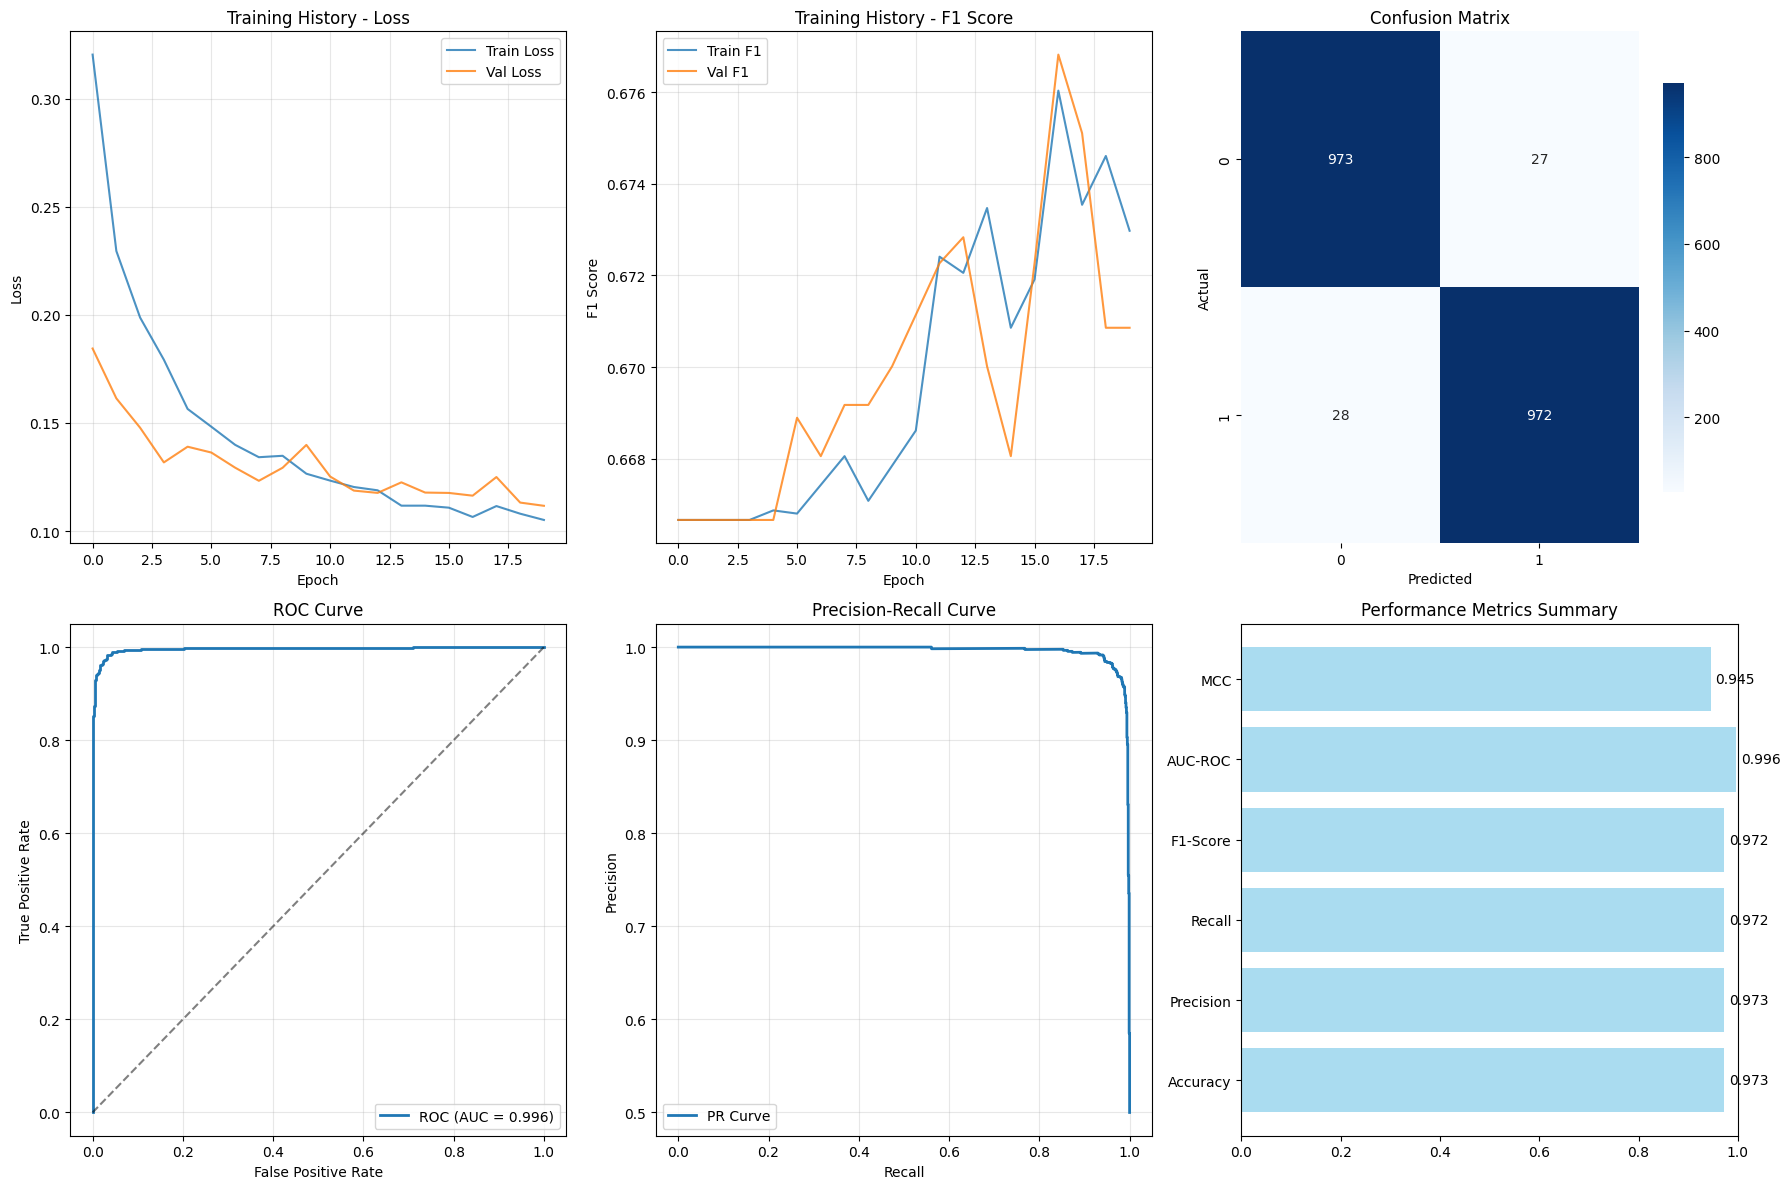


IMPLEMENTACIÓN COMPLETADA SEGÚN METODOLOGÍA


In [20]:
# Entrenar modelo final con mejores hiperparámetros
final_model = nn_model.train_final_model(
    X_train, y_train, X_val, y_val, 
    best_hyperparams, epochs=20
)

# Evaluación final en conjunto de prueba
print("\n" + "="*60)
print("EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA")
print("="*60)

test_metrics = nn_model.evaluate_comprehensive(X_test, y_test)

print(f"\nMétricas principales:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1_score']:.4f}")
print(f"AUC-ROC: {test_metrics['auc_roc']:.4f}")

print(f"\nMétricas complementarias:")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"Matthews Correlation Coefficient: {test_metrics['mcc']:.4f}")

# Verificar criterios de selección según metodología
print(f"\n" + "="*60)
print("VERIFICACIÓN DE CRITERIOS DE SELECCIÓN")
print("="*60)

print(f"✓ F1-Score maximizado: {test_metrics['f1_score']:.4f}")
print(f"{'✓' if test_metrics['auc_roc'] >= 0.90 else '✗'} AUC-ROC ≥ 0.90: {test_metrics['auc_roc']:.4f}")

# Visualizaciones
nn_model.plot_comprehensive_results(test_metrics)
